In [9]:
%pylab inline
from __future__ import division
import scipy as sp
from scipy import stats
from scipy.signal import argrelextrema
from scipy.interpolate import interp1d
# import csv
from decimal import *
import pickle
import mpld3
mpld3.enable_notebook()

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [10]:
import operator as op
def nCr(n, r):
    r = min(r, n-r)
    if r == 0: return 1
    numer = reduce(op.mul, xrange(n, n-r, -1))
    denom = reduce(op.mul, xrange(1, r+1))
    return numer//denom


In [11]:
def Q(x):
    return 0.5*sp.special.erfc(x/sqrt(2))

def Qinv(x):
    return (sqrt(2)*sp.special.erfinv(1-2*x))**2

In [126]:
# For scipy Linear Interpolation
# rate = num_nodes * 160 / 10,000
def hs_rs_table(rate, blocklength):
    rate = rate * 7/4
    k = (1-rate)*blocklength
    msg = rate*blocklength
    op_SNR = arange(-5, 10, 0.01)
    pbitdrop = Q(sqrt(2*10**(op_SNR/10)))
#     pbitdrop = array([0.5*math.erfc(sqrt(10**(opsnr/10)/2)) for opsnr in op_SNR])
    hcerr = 1 - ((1-pbitdrop)**7 + 7*pbitdrop*(1-pbitdrop)**6)
    hcflst = 1 - (1-hcerr)**3
    reeddrop = [sum([nCr(blocklength, d)* hcf**d *(1-hcf)**(blocklength-d) for d in range(int(k/2)+1, blocklength)]) \
                for hcf in hcflst]
#     func = interp1d(op_SNR, reeddrop, kind='linear', bounds_error=False, fill_value=(1.0, 0.0))
    return [op_SNR, reeddrop]

In [30]:
def shannon_table(rate):
    op_SNR = arange(-20, 5, 0.01)
    shannon = []
    for SNR in op_SNR:
        C = log2(1 + 10**(SNR/10))
        if rate > C:
            shannon.append(1.0) # pr failure
        else:
            shannon.append(0.0)
#     shannon = 1 - exp(-(2**rate -1)/op_SNR)
    return [op_SNR, array(shannon)]

In [38]:
def hard_bin_shannon_table(rate):
    op_SNR = arange(-20, 5, 0.01)
    shannon = []
    SNR = 2*10**(op_SNR/10)
    pbit = Q(sqrt(SNR))
    for p in pbit:
        C = 1 + p*log2(p) + (1-p)*log2(1-p)
        if rate > C:
            shannon.append(1.0) # pr failure
        else:
            shannon.append(0.0)
    return [op_SNR, array(shannon)]

In [15]:
def save_table(table, filename):
    f = open(filename, 'w')
    pickle.dump(table, f)
    f.close()
    
def load_table(filename):
    f = open(filename, 'r')
    table = pickle.load(f)
    f.close()
    return table

/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: divide by zero encountered in log10


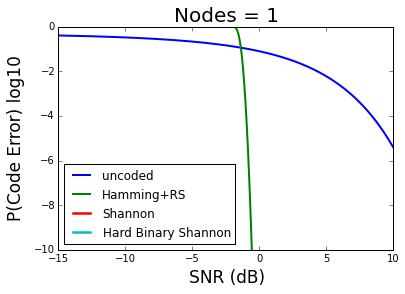

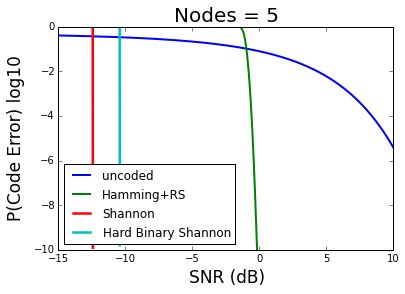

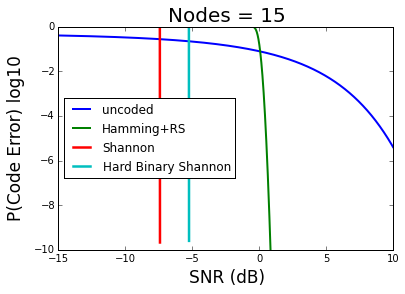

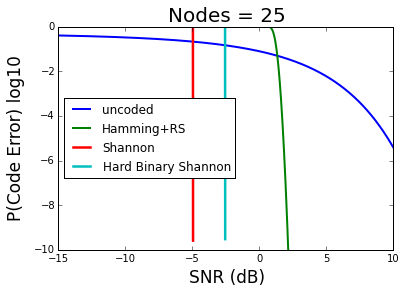

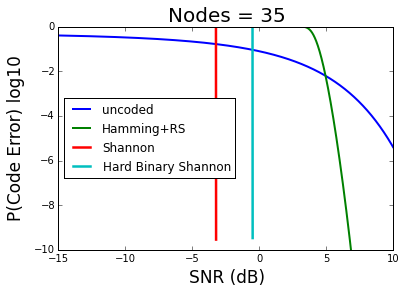

In [131]:
SNR = arange(-15, 10, 0.01)
uncoded = Q(sqrt(2*10**(SNR/10)))
# print(uncoded)

for N in [1, 5, 15, 25, 35]:
    rate = N*160/10000
    filename = 'lookup_0-01/n' + str(N) + '.in'
    codetable = load_table(filename)
    func = interp1d(codetable[0], codetable[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))

    shannonfile = 'shannon_tables/n' + str(N) + '.in'
    shannontable = load_table(shannonfile)
    shannon = interp1d(shannontable[0], shannontable[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))
    # When the red line ends, draw a vertical line down
    
    hardshannonfile = 'hard_shannon_tables/n' + str(N) + '.in'
    hardshannontable = load_table(hardshannonfile)
    hardshannon = interp1d(hardshannontable[0], hardshannontable[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))

    figure()
    plot(SNR, log10(uncoded), lw=2.0, label='uncoded')
    plot(SNR, log10(func(SNR)), lw=2.0, label='Hamming+RS')
    plot(SNR, log10(shannon(SNR)), lw=2.5, label='Shannon')
    plot(SNR, log10(hardshannon(SNR)), lw=2.5, label='Hard Binary Shannon')
    legend(loc=0)
    xlabel('SNR (dB)', fontsize=17)
    ylabel('P(Code Error) log10', fontsize=17, labelpad=10)
    ylim([-10, 0])
    title('Nodes = {0}'.format(N), fontsize=20)

    savefig('waterfall{0}.pdf'.format(N), bbox='tight')

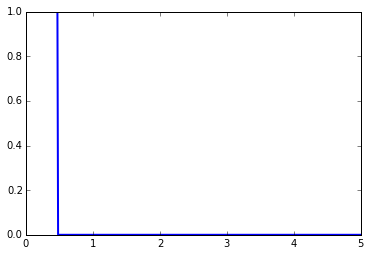

In [43]:
rate = 35*160/10000
z = shannon_table(rate)
plot(z[0], z[1], lw=2.0)

In [31]:
num_nodes = arange(1, 36)
for n in num_nodes:
    filename = 'shannon_tables/n' + str(n) + '.in'
    rate = n*160/10000
    table = shannon_table(rate)
    save_table(table, filename)

In [39]:
num_nodes = arange(1, 36)
for n in num_nodes:
    filename = 'hard_shannon_tables/n' + str(n) + '.in'
    rate = n*160/10000
    table = hard_bin_shannon_table(rate)
    save_table(table, filename)

In [127]:
num_nodes = arange(1, 36)
blocklength = int(10000/21)
for n in num_nodes:
    filename = 'lookup_0-01/n' + str(n) + '.in'
    rate = n*160/10000
    table = hs_rs_table(rate, blocklength)
    save_table(table, filename)

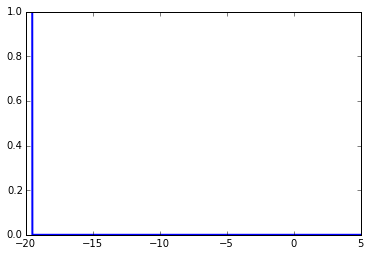

In [35]:
filename = 'shannon_tables/n' + str(1) + '.in'
codetable = load_table(filename)
plot(codetable[0], codetable[1], lw=2.0)

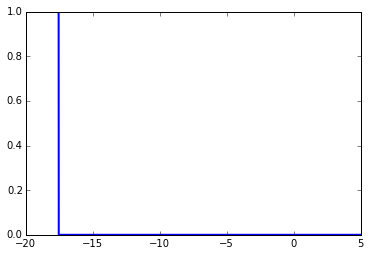

In [42]:
filename = 'hard_shannon_tables/n' + str(1) + '.in'
codetable = load_table(filename)
plot(codetable[0], codetable[1], lw=2.0)
# func = interp1d(codetable[0], codetable[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))

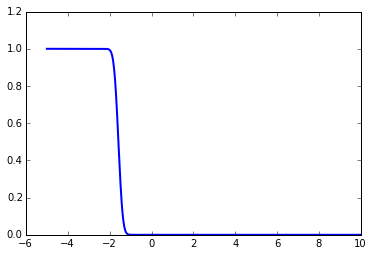

In [153]:
filename = 'lookup_0-01/n' + str(1) + '.in'
codetable = load_table(filename)
plot(codetable[0], codetable[1], lw=2.0)
# print(codetable[1])
# func = interp1d(codetable[0], codetable[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))

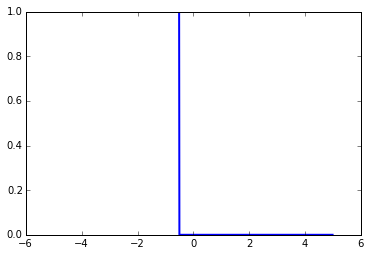

In [19]:
table = hard_bin_shannon_table(0.56)
plot(table[0], table[1], lw=2.0)

# Hockey

In [1]:
def shannon_combo(N, a, rate1, p1, SNR):
    rate2 = (N-a)/N*rate1 + 2*N/10000
    p2 = 1 - exp(-(2**rate2 -1)/(10**(SNR/10)))
    return p2**a * min(p2/p1, 1)

In [219]:
def adaptive_endpoints(fx, fade):
    grad = np.gradient(fx, 10**(-3))*10**(-3) # Magic
#     grad2 = np.gradient(grad, 10**(-4))*10**(-4)
    
    ind = argrelextrema(grad, np.less)[0]
    ind = ind[np.argsort(grad[ind])]
    if len(ind) > 0:
        mid = fade[ind[0]]
        end1, end2 = mid - 5000*10**(-9), mid + 5000*10**(-9) # Magic
    else:
        mid = 0
        end1, end2 = fade[0], fade[0]+10**(-3)
    
    endpts = [end1, end2, 2]
    return endpts

In [224]:
# Adaptive
def p_single(codetable, op_SNR, endpoint, dfade):
    fadexp = sp.stats.expon()
    fade = arange(0, endpoint, 10**(-3)) # Magic
    psingle = []
#     snrlookup = codetable(op_SNR+log10(fade))
#     fadepr = fadexp.pdf(fade)
    optimize = codetable(op_SNR+10*log10(fade)) * fadexp.pdf(fade)
    endpts = adaptive_endpoints(optimize, fade)
#     print(op_SNR, endpts)
#     dfade = [10**(-2), 10**(-5), 10**(-2)]
    fade = arange(0, endpts[0], dfade[0])
    fadepr = fadexp.pdf(fade)
    snrlookup = codetable(op_SNR+10*log10(fade))
    psingle.append(dfade[0]*np.dot(snrlookup, fadepr))
    for idx in range(1, len(endpts)):
        fade = arange(endpts[idx-1], endpts[idx], dfade[idx])
        snrlookup = codetable(op_SNR+10*log10(fade))
        fadepr = fadexp.pdf(fade)
        psingle.append(dfade[idx]*np.dot(snrlookup, fadepr))
    return sum(psingle)

In [225]:
def p_combo(codetable, a, op_SNR, endpoint, dfade):
    if a == 0:
        return 1.0
    fadexp = sp.stats.erlang(a)
    pcombo = []
    fade = arange(0, endpoint, 10**(-3))
    snrlookup = codetable(op_SNR+10*log10(fade))
    fadepr = fadexp.pdf(fade)
    optimize = snrlookup * fadepr
    endpts = adaptive_endpoints(optimize, fade)
    fade = arange(0, endpts[0], dfade[0])
    snrlookup = codetable(op_SNR+10*log10(fade))
    fadepr = fadexp.pdf(fade)
    pcombo.append(dfade[0]*np.dot(snrlookup, fadepr))
    for idx in range(1, len(endpts)):
        fade = arange(endpts[idx-1], endpts[idx], dfade[idx])
        snrlookup = codetable(op_SNR+10*log10(fade))
        fadepr = fadexp.pdf(fade)
        pcombo.append(dfade[idx]*np.dot(snrlookup, fadepr))
#         pcombo.append(sum([snr_lookup(codetable, kmin, kmax, op_SNR+log10(f), tabledSNR) * fadexp.pdf(f) * dfade[idx] for f in fade]))
    return sum(pcombo)

In [203]:
# N = num_nodes
def p_protocol(codetable, N, op_SNR, endpoint, dfade):
    psingle = p_single(codetable, op_SNR, endpoint, dfade)
#     print('psingle', psingle)
#     print('psingle', psingle, 'pcombo, ')
    return sum([nCr(N, a) * (1-psingle)**a * psingle**(N-a) * 
                (1-(1-p_combo(codetable, a, op_SNR, endpoint, dfade))**(N-a)) for a in range(N)])

In [232]:
def hockey(codingscheme, dSNR, dfade, endpoint, threshold, start_SNR, start_nodes, end_nodes):
    nominal_needed = []
    for N in range(start_nodes, end_nodes):
        filename = codingscheme + '/n' + str(N) + '.in'
        codetable = load_table(filename)
        func = interp1d(codetable[0], codetable[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))
        SNR = start_SNR-dSNR # dB scale
        pprotocol = 1.0
        while pprotocol > threshold:
            SNR += dSNR
            pprotocol = p_protocol(func, N, SNR, end, dfade)
        print('P(protocol)', N, SNR, pprotocol)
        nominal_needed.append(SNR)

    plot(range(start_nodes, end_nodes), array(nominal_needed), lw=2.0, label=codingscheme)
    xlabel('Number of Nodes', fontsize=18)
    ylabel('Nominal SNR Needed (dB)', fontsize=18, labelpad=20)
    title('Hockey {0}'.format(threshold), fontsize=24)
    
    return array(nominal_needed)

In [17]:
hamming = []
shannon = []
hardbinshannon = []

/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log10


CPU times: user 32min 7s, sys: 5min 5s, total: 37min 12s
Wall time: 26min


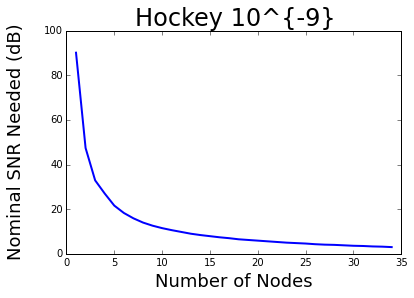

In [18]:
%%time
# Hockey Stick Plot Adaptive
nominal_needed = []
# shannon = []
dSNR = 0.01
dfade = [10**(-3), 10**(-10), 10**(-3)]
end = 2
threshold = 10**(-9)
for N in range(1, 35):
    filename = 'lookup_0-01/n' + str(N) + '.in'
    codetable = load_table(filename)
    func = interp1d(codetable[0], codetable[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))
    SNR = 0 # dB scale
    pprotocol = 1.0
    while pprotocol > threshold:
        pprotocol = p_protocol(func, N, SNR, end, dfade, dSNR)
        SNR += 0.01
#         print(SNR, pprotocol)
    nominal_needed.append(SNR-0.01)

hamming = 10*array(nominal_needed)
    
plot(range(1, 35), 10*array(nominal_needed), lw=2.0, label='4-3 Hamming')
xlabel('Number of Nodes', fontsize=18)
ylabel('Nominal SNR Needed (dB)', fontsize=18, labelpad=20)
title('Hockey 10^{-9}', fontsize=24)
savefig('hockey_ecc.pdf', bbox='tight')

/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log10


CPU times: user 20min 51s, sys: 5min 28s, total: 26min 20s
Wall time: 21min 59s


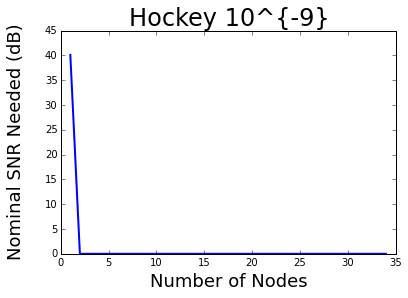

In [20]:
%%time
# Hockey Stick Plot Adaptive
nominal_needed = []
dSNR = 0.01
dfade = [10**(-3), 10**(-10), 10**(-3)]
end = 2
threshold = 10**(-9)
for N in range(1, 35):
    filename = 'shannon_tables/n' + str(N) + '.in'
    codetable = load_table(filename)
    func = interp1d(codetable[0], codetable[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))
    SNR = 0 # dB scale
    pprotocol = 1.0
    while pprotocol > threshold:
        pprotocol = p_protocol(func, N, SNR, end, dfade, dSNR)
        SNR += 0.01
#         print(SNR, pprotocol)
    nominal_needed.append(SNR-0.01)

shannon = 10*array(nominal_needed)
    
plot(range(1, 35), 10*array(nominal_needed), lw=2.0, label='4-3 Hamming')
xlabel('Number of Nodes', fontsize=18)
ylabel('Nominal SNR Needed (dB)', fontsize=18, labelpad=20)
title('Hockey 10^{-9}', fontsize=24)
# savefig('hockey_ecc.pdf', bbox='tight')

/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log10


CPU times: user 13min 21s, sys: 3min 25s, total: 16min 47s
Wall time: 13min 28s


/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10


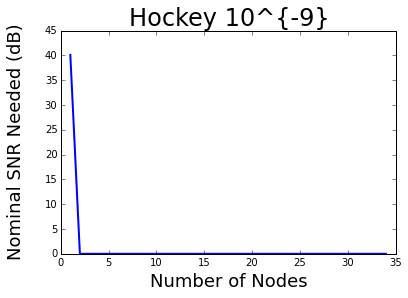

In [21]:
%%time
# Hockey Stick Plot Adaptive
nominal_needed = []
dSNR = 0.01
dfade = [10**(-3), 10**(-10), 10**(-3)]
end = 2
threshold = 10**(-9)
for N in range(1, 35):
    filename = 'hard_shannon_tables/n' + str(N) + '.in'
    codetable = load_table(filename)
    func = interp1d(codetable[0], codetable[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))
    SNR = 0 # dB scale
    pprotocol = 1.0
    while pprotocol > threshold:
        pprotocol = p_protocol(func, N, SNR, end, dfade, dSNR)
        SNR += 0.01
#         print(SNR, pprotocol)
    nominal_needed.append(SNR-0.01)

hardbinshannon = 10*array(nominal_needed)
    
plot(range(1, 35), 10*array(nominal_needed), lw=2.0, label='4-3 Hamming')
xlabel('Number of Nodes', fontsize=18)
ylabel('Nominal SNR Needed (dB)', fontsize=18, labelpad=20)
title('Hockey 10^{-9}', fontsize=24)
# savefig('hockey_ecc.pdf', bbox='tight')

In [19]:
print(hamming)

[ 90.1  47.4  32.9  27.   21.6  18.3  15.9  14.   12.6  11.5  10.6   9.8
   9.    8.4   7.9   7.4   7.    6.5   6.2   5.9   5.6   5.3   5.    4.8
   4.6   4.3   4.1   4.    3.8   3.6   3.5   3.3   3.2   3. ]


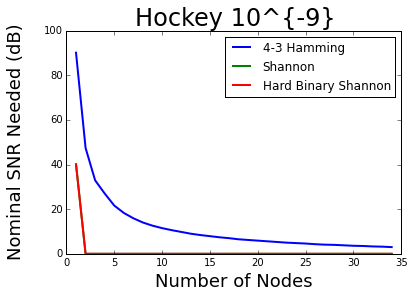

In [23]:
plot(range(1, 35), hamming, lw=2.0, label='4-3 Hamming')
plot(range(1, 35), shannon, lw=2.0, label='Shannon')
plot(range(1, 35), hardbinshannon, lw=2.0, label='Hard Binary Shannon')
legend(loc=0)
xlabel('Number of Nodes', fontsize=18)
ylabel('Nominal SNR Needed (dB)', fontsize=18, labelpad=20)
title('Hockey 10^{-9}', fontsize=24)
# savefig('hockey_ecc.pdf', bbox='tight')

In [24]:
print(shannon)
print(hardbinshannon)

[ 40.1   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0. ]
[ 40.1   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0. ]


/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: divide by zero encountered in log10


ERROR! Session/line number was not unique in database. History logging moved to new session 253
[ 1.          0.9990005   0.998002   ...,  0.1357419   0.13560622
  0.13547069]


/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: divide by zero encountered in log10


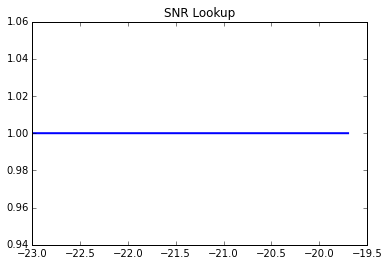

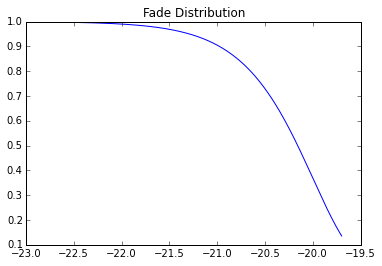

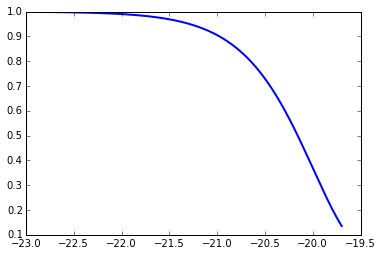

In [67]:
dSNR = 0.01
dfade = [10**(-3), 10**(-10), 10**(-3)]
op_SNR = -20

filename = 'shannon_tables/n' + str(1) + '.in'
table = load_table(filename)
codetable = interp1d(table[0], table[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))

fadexp = sp.stats.expon()
fade = arange(0, 2, 10**(-3)) # Magic
# fade = fade + 10**(-6)
psingle = []

figure()
plot(op_SNR+log10(fade), codetable(op_SNR+log10(fade)), lw=2.0)
title('SNR Lookup')

figure()
plot(op_SNR+log10(fade), fadexp.pdf(fade))
title('Fade Distribution')

optimize = codetable(op_SNR+log10(fade)) * fadexp.pdf(fade)
figure()
plot(op_SNR+log10(fade), optimize, lw=2.0)
print(optimize)
# endpts = adaptive_endpoints(optimize, fade)

# fade = arange(0, endpts[0], dfade[0])
# fadepr = fadexp.pdf(fade)
# snrlookup = codetable(op_SNR+log10(fade))
# psingle.append(dfade[0]*np.dot(snrlookup, fadepr))
# for idx in range(1, len(endpts)):
#     fade = arange(endpts[idx-1], endpts[idx], dfade[idx])
#     snrlookup = codetable(op_SNR+log10(fade))
#     fadepr = fadexp.pdf(fade)
#     psingle.append(dfade[idx]*np.dot(snrlookup, fadepr))
# print(sum(psingle))

/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:39: RuntimeWarning: divide by zero encountered in log10


[1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10]


TypeError: p_protocol() takes exactly 5 arguments (6 given)

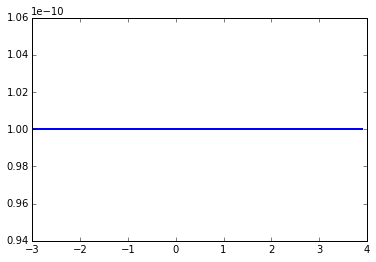

In [111]:
filename = 'shannon_tables/n' + str(1) + '.in'
table = load_table(filename)
# plot(table[0], table[1], lw=2.0)
# title('Original Shannon Table')

# figure()
codetable = interp1d(table[0], table[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))
# plot(table[0], codetable(table[0]), lw=2.0) # table resolution = 0.01
# title('Interpolated Shannon Table')

test = []
endpoint = 2
dfade = [10**(-3), 10**(-10), 10**(-3)]
dSNR = 0.01

for op_SNR in arange(-3, 4, 0.1):
    fade = arange(0, 2, 10**(-3))
#     print(log10(fade))
#     # op_SNR = 5
#     # print(op_SNR+log10(fade))
#     print(codetable(op_SNR+log10(fade)))
#     figure()
#     plot(fade, codetable(op_SNR+log10(fade)), lw=2.0)
#     title('SNR Lookup')

    optimize = codetable(op_SNR+log10(fade)) * fadexp.pdf(fade)
#     figure()
#     plot(fade, optimize, lw=2.0)
#     print(optimize)

    endpts = adaptive_endpoints(optimize, fade)
    psingle = []
    fade = arange(0, endpts[0], dfade[0])
    fadepr = fadexp.pdf(fade)
    snrlookup = codetable(op_SNR+log10(fade))
    psingle.append(dfade[0]*np.dot(snrlookup, fadepr))
    for idx in range(1, len(endpts)):
        fade = arange(endpts[idx-1], endpts[idx], dfade[idx])
        snrlookup = codetable(op_SNR+log10(fade))
        fadepr = fadexp.pdf(fade)
        psingle.append(dfade[idx]*np.dot(snrlookup, fadepr))
    test.append(sum(psingle))
    
plot(arange(-3, 4, 0.1), test, lw=2.0)
print(test)
z = p_protocol(codetable, 35, op_SNR, endpoint, dfade, dSNR)
print(z)

/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log10


[1.5368821487868835e-08, 5.1581859878202533e-11, 1.0921880661862212e-13, 1.5898719099830888e-16, 1.7228739701786679e-19, 1.4650775441086434e-22, 1.0189661042548834e-25, 6.2061826272897854e-29, 3.3107262791460697e-32, 1.5737449612930587e-35, 7.0141812660918325e-39, 3.0853723045776281e-42, 1.2705284473274959e-45, 5.6684236575099207e-49, 2.6342846445800075e-52, 1.0063249215736615e-55, 2.4575195653090921e-59, 1.0199574754930745e-62, 1.7399274365361252e-65, 6.8304584368847612e-69, 2.1815778151678633e-73, 3.5015693873573812e-76, 1.2978831029791004e-79, 4.4505168580668927e-84, 4.4505168580668927e-84, 1.4179903755021015e-90, 1.4179903755021015e-90, 1.4179903755021015e-90, 6.6485125401728333e-102, 2.1070112534920587e-105, 6.6831922150338863e-109, 2.1096710625207769e-112, 6.8199516205421897e-116, 2.2592985224154339e-119, 6.4324844691262227e-123, 8.6246290819689151e-127, 2.7293106173643859e-130, 8.6357124704407938e-134, 2.7324968845795367e-137, 8.6452576819815355e-141, 2.7332721875379445e-144, 8.

/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log10


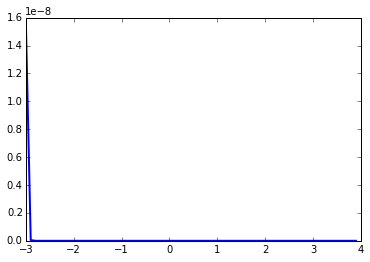

In [98]:
%%time
filename = 'shannon_tables/n' + str(35) + '.in'
table = load_table(filename)
codetable = interp1d(table[0], table[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))

test = []
endpoint = 2
dfade = [10**(-3), 10**(-10), 10**(-3)]
dSNR = 0.01

for op_SNR in arange(-3, 4, 0.1):
    fade = arange(0, 2, 10**(-3))
    z = p_protocol(codetable, 35, op_SNR, endpoint, dfade, dSNR)
    test.append(z)

    
plot(arange(-3, 4, 0.1), test, lw=2.0)
print(test)

In [205]:
%%time
# filename = 'shannon_tables/n' + str(35) + '.in'
# table = load_table(filename)
# codetable = interp1d(table[0], table[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))

threshold = 10**(-9)
endpoint = 2
dfade = [10**(-3), 10**(-10), 10**(-3)]
dSNR = 0.01
codingscheme = 'lookup_0-01'
start_nodes, end_nodes = 1, 35
start_SNR = 0

test = hockey(codingscheme, dSNR, dfade, endpoint, threshold, start_SNR, start_nodes, end_nodes)
print(test)

/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log10


('P(protocol)', 1, 7.489999999999885, 9.831048710442653e-10)
('P(protocol)', 2, 3.3099999999999734, 9.7390830936302204e-10)
('P(protocol)', 3, 1.9600000000000015, 9.7521997475833697e-10)
('P(protocol)', 4, 1.420000000000001, 9.4152328366896209e-10)
('P(protocol)', 5, 1.0200000000000007, 9.336577521017412e-10)
('P(protocol)', 6, 0.7900000000000005, 8.7930408005288645e-10)
('P(protocol)', 7, 0.6600000000000004, 8.9334377576442004e-10)
('P(protocol)', 8, 0.5900000000000003, 8.4712586476878651e-10)
('P(protocol)', 9, 0.5400000000000003, 8.2914716161287009e-10)
('P(protocol)', 10, 0.5300000000000002, 8.3713824524839872e-10)
('P(protocol)', 11, 0.5400000000000003, 8.4409560479989599e-10)
('P(protocol)', 12, 0.5500000000000003, 8.5137939165588673e-10)
('P(protocol)', 13, 0.5900000000000003, 8.0785607274051338e-10)
('P(protocol)', 14, 0.6400000000000003, 7.6828847754087372e-10)
('P(protocol)', 15, 0.6800000000000004, 7.9050403011532105e-10)
('P(protocol)', 16, 0.7400000000000004, 9.17924004906

KeyboardInterrupt: 

/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log10


('P(protocol)', 1, 88.69999999999924, 9.899003667855336e-10)
('P(protocol)', 2, 46.000000000000384, 9.6083006566007613e-10)
('P(protocol)', 3, 31.500000000000178, 9.5488041921070646e-10)
('P(protocol)', 4, 25.600000000000094, 9.6867755832444733e-10)
('P(protocol)', 5, 20.30000000000002, 9.5607225034860108e-10)
('P(protocol)', 6, 17.099999999999973, 9.5964420904178462e-10)
('P(protocol)', 7, 14.899999999999963, 9.0776837038697074e-10)
('P(protocol)', 8, 13.199999999999969, 9.3440531911795779e-10)
('P(protocol)', 9, 11.899999999999974, 8.8772404518811528e-10)
('P(protocol)', 10, 10.799999999999978, 9.8484512360632357e-10)
('P(protocol)', 11, 9.99999999999998, 8.6337531335217256e-10)
('P(protocol)', 12, 9.299999999999983, 8.0019432681302991e-10)
('P(protocol)', 13, 8.699999999999985, 7.948159948000265e-10)
('P(protocol)', 14, 8.199999999999987, 7.6911930792760584e-10)
('P(protocol)', 15, 7.699999999999989, 8.8635671776859416e-10)
('P(protocol)', 16, 7.29999999999999, 9.6395355769461258e-1

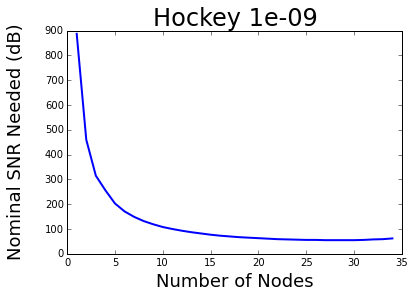

In [231]:
%%time

threshold = 10**(-9)
endpoint = 2
dfade = [10**(-3), 10**(-10), 10**(-3)]
dSNR = 0.1
codingscheme = 'lookup_0-01'
start_nodes, end_nodes = 1, 35
start_SNR = 0

hamming2 = hockey(codingscheme, dSNR, dfade, endpoint, threshold, start_SNR, start_nodes, end_nodes)
print(hamming2)




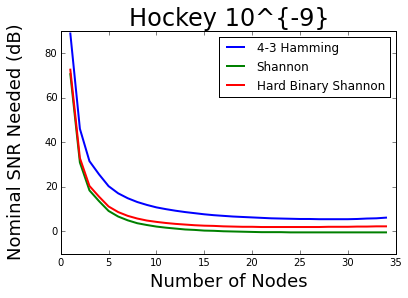

In [244]:
plot(range(1, 35), hamming2, lw=2.0, label='4-3 Hamming')
plot(range(1, 35), shannon2, lw=2.0, label='Shannon')
plot(range(1, 35), hardshannon2, lw=2.0, label='Hard Binary Shannon')
legend(loc=0)
xlabel('Number of Nodes', fontsize=18)
ylabel('Nominal SNR Needed (dB)', fontsize=18, labelpad=20)
title('Hockey 10^{-9}', fontsize=24)
savefig('hockey_ecc_2.pdf', bbox='tight')uuu

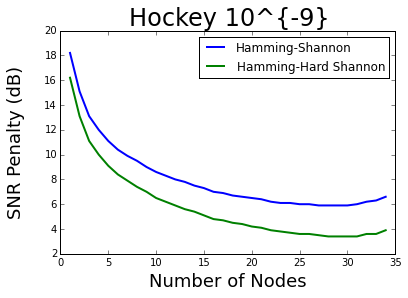

In [245]:
plot(range(1, 35), hamming2-shannon2, lw=2.0, label='Hamming-Shannon')
plot(range(1, 35), hamming2-hardshannon2, lw=2.0, label='Hamming-Hard Shannon')
legend(loc=0)
xlabel('Number of Nodes', fontsize=18)
ylabel('SNR Penalty (dB)', fontsize=18, labelpad=20)
title('Hockey 10^{-9}', fontsize=24)
savefig('penalty_ecc_2.pdf', bbox='tight')

/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log10


('P(protocol)', 1, 70.50000000000027, 9.9999999954999995e-10)
('P(protocol)', 2, 30.900000000000173, 9.9565904827263384e-10)
('P(protocol)', 3, 18.399999999999995, 9.9383263269915651e-10)
('P(protocol)', 4, 13.59999999999997, 2.6315837168234818e-10)
('P(protocol)', 5, 9.199999999999985, 6.0134375000344269e-10)
('P(protocol)', 6, 6.699999999999993, 7.3153415469497938e-10)
('P(protocol)', 7, 4.999999999999999, 8.2926738387926592e-10)
('P(protocol)', 8, 3.700000000000003, 9.9666389504800587e-10)
('P(protocol)', 9, 2.900000000000002, 8.2587166396554533e-10)
('P(protocol)', 10, 2.2000000000000015, 8.9409276847109022e-10)
('P(protocol)', 11, 1.7000000000000013, 8.3653653338470172e-10)
('P(protocol)', 12, 1.300000000000001, 8.1378849734852918e-10)
('P(protocol)', 13, 0.9000000000000006, 9.6912711993049753e-10)
('P(protocol)', 14, 0.7000000000000006, 7.9848347121820002e-10)
('P(protocol)', 15, 0.4000000000000007, 9.8439649604128353e-10)
('P(protocol)', 16, 0.30000000000000066, 7.80711016333687

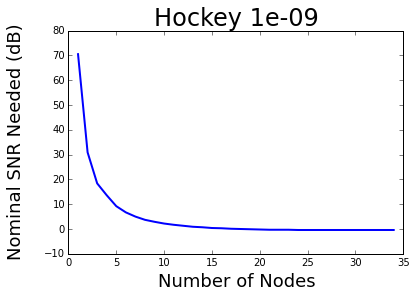

In [240]:
%%time

threshold = 10**(-9)
endpoint = 2
dfade = [10**(-3), 10**(-10), 10**(-3)]
dSNR = 0.1
codingscheme = 'shannon_tables'
start_nodes, end_nodes = 1, 35
start_SNR = -2

shannon2 = hockey(codingscheme, dSNR, dfade, endpoint, threshold, start_SNR, start_nodes, end_nodes)
print(shannon2)




/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log10


('P(protocol)', 1, 72.50000000000016, 9.9999999954999995e-10)
('P(protocol)', 2, 32.9000000000002, 9.9108448790035649e-10)
('P(protocol)', 3, 20.40000000000002, 9.8699430558909174e-10)
('P(protocol)', 4, 15.59999999999996, 2.6315837168234818e-10)
('P(protocol)', 5, 11.199999999999976, 6.0134375000344269e-10)
('P(protocol)', 6, 8.699999999999985, 7.3153415469497938e-10)
('P(protocol)', 7, 6.999999999999991, 8.2926738387926592e-10)
('P(protocol)', 8, 5.799999999999995, 9.9666389504800587e-10)
('P(protocol)', 9, 4.899999999999999, 9.6767977111183985e-10)
('P(protocol)', 10, 4.300000000000001, 8.9409276847109022e-10)
('P(protocol)', 11, 3.800000000000002, 8.3653653338470172e-10)
('P(protocol)', 12, 3.4000000000000017, 8.7307040100311716e-10)
('P(protocol)', 13, 3.1000000000000014, 8.3240103592183861e-10)
('P(protocol)', 14, 2.800000000000001, 8.9881160970083995e-10)
('P(protocol)', 15, 2.600000000000001, 8.8141857667193882e-10)
('P(protocol)', 16, 2.500000000000001, 7.3973333365127504e-10)

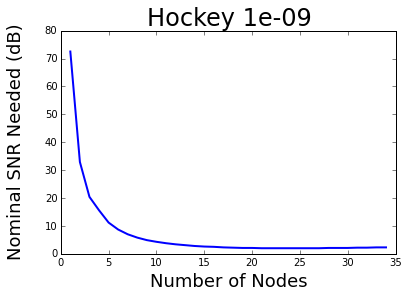

In [243]:
%%time

threshold = 10**(-9)
endpoint = 2
dfade = [10**(-3), 10**(-10), 10**(-3)]
dSNR = 0.1
codingscheme = 'hard_shannon_tables'
start_nodes, end_nodes = 1, 35
start_SNR = -1

hardshannon2 = hockey(codingscheme, dSNR, dfade, endpoint, threshold, start_SNR, start_nodes, end_nodes)
print(hardshannon2)

/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log10


('endpts', [0.056995000000000004, 0.057005, 2])
0.534092646562
CPU times: user 131 ms, sys: 52.6 ms, total: 184 ms
Wall time: 242 ms


/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in log10


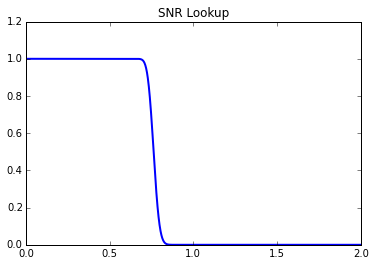

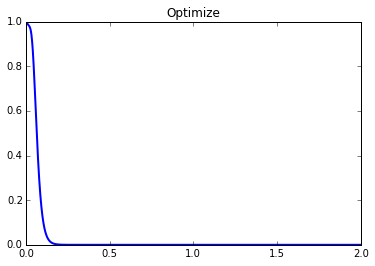

In [223]:
%%time
def p_single(codetable, op_SNR, endpoint, dfade):
    fadexp = sp.stats.expon()
    fade = arange(0, endpoint, 10**(-3)) # Magic
    psingle = []
    snrlookup = codetable(op_SNR+10*log10(fade))
    plot(fade, snrlookup, lw=2.0)
    title('SNR Lookup')
#     fadepr = fadexp.pdf(fade)
    optimize = codetable(op_SNR+log10(fade)) * fadexp.pdf(fade)
    figure()
    plot(fade, optimize, lw=2.0)
    title('Optimize')
    endpts = adaptive_endpoints(optimize, fade)
    print('endpts', endpts)
#     print(op_SNR, endpts)
#     dfade = [10**(-2), 10**(-5), 10**(-2)]
    fade = arange(0, endpts[0], dfade[0])
    fadepr = fadexp.pdf(fade)
    snrlookup = codetable(op_SNR+10*log10(fade))
    psingle.append(dfade[0]*np.dot(snrlookup, fadepr))
    for idx in range(1, len(endpts)):
        fade = arange(endpts[idx-1], endpts[idx], dfade[idx])
        snrlookup = codetable(op_SNR+10*log10(fade))
        fadepr = fadexp.pdf(fade)
        psingle.append(dfade[idx]*np.dot(snrlookup, fadepr))
    return sum(psingle)

N = 10
filename = 'lookup_0-01/n' + str(N) + '.in'
codetable = load_table(filename)
func = interp1d(codetable[0], codetable[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))
SNR = 0.5
z = p_single(func, SNR, end, dfade)
print(z)

/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log10


('endpts', [0.056995000000000004, 0.057005, 2])
('endpts', [0.074994999999999992, 0.075005000000000002, 2])
('endpts', [0.092994999999999994, 0.093005000000000004, 2])
('endpts', [0.10899499999999999, 0.109005, 2])
('endpts', [0.127995, 0.12800500000000001, 2])
('endpts', [0.14699499999999999, 0.147005, 2])
('endpts', [0.164995, 0.16500500000000001, 2])
('endpts', [0.193995, 0.19400500000000001, 2])
('endpts', [0.227995, 0.22800500000000001, 2])
[2.3807622463141645e-12, 1.5257229886666395e-10, 4.2259277667376258e-10, 4.0949493776585349e-10, 2.1637056335423813e-10, 6.9416940093642063e-11, 1.4066673765878404e-11, 1.7833231655146581e-12, 1.3085097733701727e-13, 4.3032542879651103e-15]
CPU times: user 1.1 s, sys: 58.6 ms, total: 1.16 s
Wall time: 915 ms


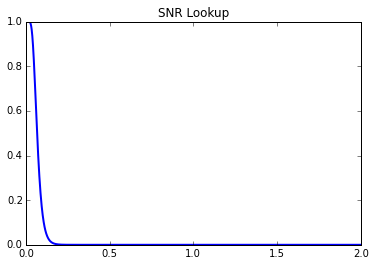

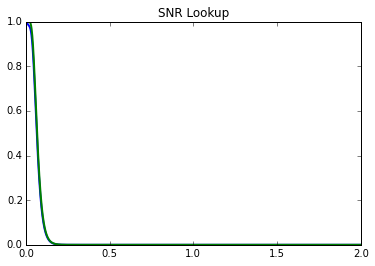

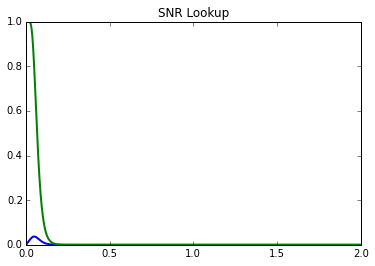

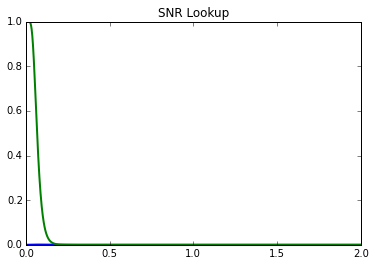

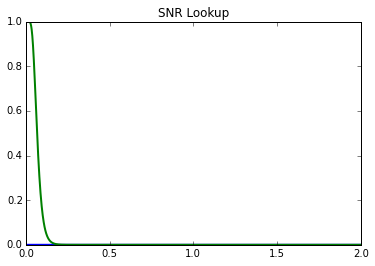

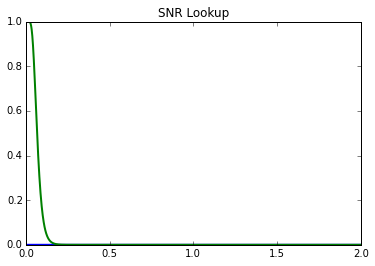

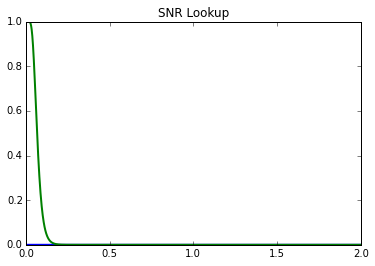

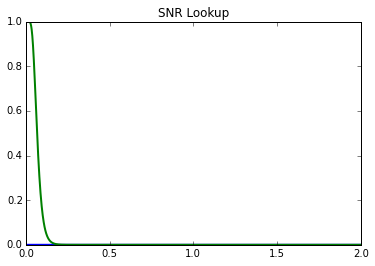

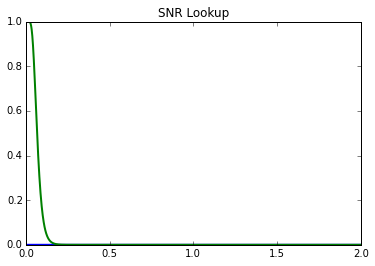

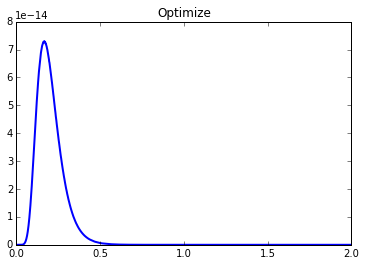

In [218]:
%%time
psingle = z
lala = [nCr(N, a) * (1-psingle)**a * psingle**(N-a) * (1-(1-p_combo(func, a, SNR, 2, dfade))**(N-a)) for a in range(N)]
print(lala)

In [216]:
SNR = 0.5
first = 45 * (1-z)**2 * z**8
second = p_combo(func, 2, SNR, 2, dfade)
third = (1-second)
print(first, second, third, third**8)

(1.9618191963728377e-08, 9.0094527387378237e-31, 1.0, 1.0)


/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10


/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log10


('endpts', [0.074994999999999992, 0.075005000000000002, 2])
('pcombo', 0.0027183303086940462)


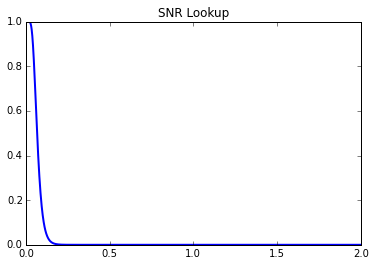

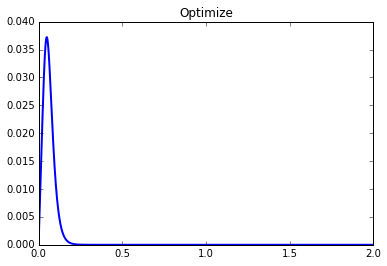

In [217]:
def p_combo(codetable, a, op_SNR, endpoint, dfade):
    if a == 0:
        return 1.0
    fadexp = sp.stats.erlang(a)
    pcombo = []
    fade = arange(0, endpoint, 10**(-3))
    snrlookup = codetable(op_SNR+log10(fade))
    plot(fade, snrlookup, lw=2.0)
    title('SNR Lookup')
    fadepr = fadexp.pdf(fade)
    optimize = snrlookup * fadepr
    figure()
    plot(fade, optimize, lw=2.0)
    title('Optimize')
    endpts = adaptive_endpoints(optimize, fade)
    print('endpts', endpts)
    fade = arange(0, endpts[0], dfade[0])
    snrlookup = codetable(op_SNR+log10(fade))
    fadepr = fadexp.pdf(fade)
    pcombo.append(dfade[0]*np.dot(snrlookup, fadepr))
    for idx in range(1, len(endpts)):
        fade = arange(endpts[idx-1], endpts[idx], dfade[idx])
        snrlookup = codetable(op_SNR+log10(fade))
        fadepr = fadexp.pdf(fade)
        pcombo.append(dfade[idx]*np.dot(snrlookup, fadepr))
#         pcombo.append(sum([snr_lookup(codetable, kmin, kmax, op_SNR+log10(f), tabledSNR) * fadexp.pdf(f) * dfade[idx] for f in fade]))
    return sum(pcombo)

SNR = 0.5
dfade = [10**(-3), 10**(-10), 10**(-3)]
z3 = p_combo(func, 2, SNR, 2, dfade)
print('pcombo', z3)

In [202]:
%%time
z3 = p_protocol(func, N, SNR, end, dfade)
print(z3)

/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log10


('psingle', 0.56951786810718574)
0.000857190993618
CPU times: user 22.7 s, sys: 6.49 s, total: 29.2 s
Wall time: 29.2 s


In [221]:
op_SNR = arange(0, 10, 0.1)
pbitdrop = array([0.5*math.erfc(sqrt(10**opsnr/2)) for opsnr in op_SNR])
print(pbitdrop)

pbitdropnew = Q(sqrt(2*10**(op_SNR/10)))
print(pbitdropnew)

[  1.58655254e-001   1.30927297e-001   1.04028637e-001   7.88958720e-002
   5.64953017e-002   3.76789881e-002   2.30071389e-002   1.25870331e-002
   6.00438640e-003   2.41331042e-003   7.82701129e-004   1.93985472e-004
   3.43026239e-005   3.96924840e-006   2.69514812e-007   9.36103999e-009
   1.39902781e-010   7.23597571e-013   9.84500244e-016   2.49451672e-019
   7.61985302e-024   1.62296193e-029   1.20974377e-036   1.32491919e-045
   7.14952467e-057   4.80352986e-071   7.11135314e-089   2.62194050e-111
   1.54731220e-139   4.61509294e-175   8.97916392e-220   4.76854671e-276
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+

In [222]:
op_SNR = 0.5
fade = arange(0, endpoint, 10**(-3))
print(op_SNR + log10(fade))
print(op_SNR + 10*log10(fade))

[       -inf -2.5        -2.19897    ...,  0.80037806  0.80059548
  0.80081279]
[        -inf -29.5        -26.48970004 ...,   3.50378065   3.50595484
   3.50812794]


/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10
